In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '../..'))
	print(os.getcwd())
except:
	pass


 # Using Joblib reproducibly

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture


 # Getting random numbers
 The following is one of the simplest ways that one could generate many random
 numbers, which are useful in almost any scientific computing application

In [2]:
np.random.seed(8888)

n_numbers = 20

outs = []
for i in range(n_numbers):
    big_number = np.random.randint(1e8)
    outs.append(big_number)
print(outs)


[28863715, 20470441, 59601088, 35178672, 31953535, 54920184, 6437049, 49557007, 32591667, 33196361, 14963174, 59717179, 32480075, 70590040, 82187373, 67242005, 76389711, 43332706, 66541139, 8632395]


 # Make the above stuff in my for loop into a function
 The first step to getting to something we can do in Joblib is to turn the stuff
 we had in a for loop into a function

In [3]:
def _get_big_number():
    big_number = np.random.randint(1e8)
    return big_number


np.random.seed(8888)

outs = []
for i in range(n_numbers):
    big_number = _get_big_number()
    outs.append(big_number)

print(outs)


[28863715, 20470441, 59601088, 35178672, 31953535, 54920184, 6437049, 49557007, 32591667, 33196361, 14963174, 59717179, 32480075, 70590040, 82187373, 67242005, 76389711, 43332706, 66541139, 8632395]


 # Now, do it in parallel
 With Joblib, parallelizing the above is super easy!

In [4]:
np.random.seed(8888)
par = Parallel(n_jobs=8)
outs = par(delayed(_get_big_number)() for _ in range(n_numbers))
print(outs)


[49298211, 960679, 7840371, 75202960, 28282479, 7528719, 99466831, 76798086, 61512489, 60087525, 55473392, 85450202, 13124747, 14944763, 92530329, 29784778, 16918058, 67836125, 81264675, 73960372]


 # But is it reproducible?

In [5]:
np.random.seed(8888)
par = Parallel(n_jobs=8)
outs = par(delayed(_get_big_number)() for _ in range(n_numbers))
print(outs)  # note that now we don't get reproducible results!


[11772194, 70427031, 91672483, 58518373, 42038149, 42933984, 3123949, 96178412, 41251378, 27098387, 98151772, 22073752, 87024182, 39619220, 78539229, 47795066, 77917795, 25815037, 54690881, 72367281]


 # Get random numbers in parallel, reproducibly
 Even when setting the random seed in the above, we did not get reproducible results.
 To make this happen, I usually just start by generating a long list of random seeds
 (starting from a random seed, of course) and then pass those seeds down to the
 individual jobs.

In [6]:
np.random.seed(8888)
seeds = np.random.randint(1e8, size=n_numbers)


def _get_big_reproducible_number(seed):
    np.random.seed(seed)
    return _get_big_number()


par = Parallel(n_jobs=4)
outs = par(delayed(_get_big_reproducible_number)(seed) for seed in seeds)
print(outs)


[46621082, 97292465, 84093849, 69981988, 69717233, 28029841, 53811122, 71335538, 50534020, 6092775, 87017978, 84213854, 7721363, 31245923, 89469332, 30208313, 81965930, 74720508, 80658938, 82125302]


 # Check that we now get reproducible results

In [7]:
np.random.seed(8888)
seeds = np.random.randint(1e8, size=n_numbers)

par = Parallel(n_jobs=4)
outs = par(delayed(_get_big_reproducible_number)(seed) for seed in seeds)
print(outs)


[46621082, 97292465, 84093849, 69981988, 69717233, 28029841, 53811122, 71335538, 50534020, 6092775, 87017978, 84213854, 7721363, 31245923, 89469332, 30208313, 81965930, 74720508, 80658938, 82125302]


 # Simple demo with Gaussian blobs

(-8.551714730149058, 7.03254519805067, -5.95587662068765, 12.951742653648202)

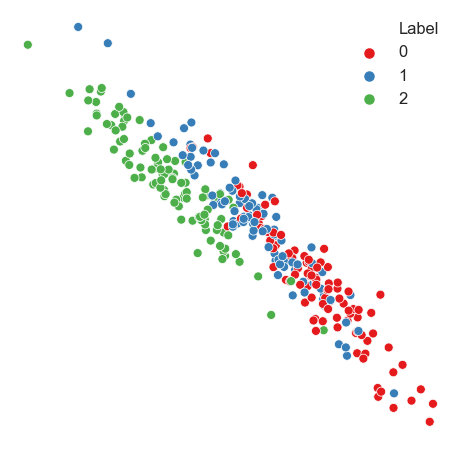

In [8]:
def generate_data(n_samples=300):
    X, y = make_blobs(n_samples=n_samples, cluster_std=2.5)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)
    return aniso


X, y = generate_data()
plot_df = pd.DataFrame(data=X)
plot_df["Label"] = y

sns.set_context("talk")
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(
    data=plot_df,
    x=0,
    y=1,
    ax=ax,
    hue="Label",
    palette=sns.color_palette("Set1", plot_df["Label"].nunique()),
)
ax.axis("off")


 # Look at the performance of two different clustering algorithms
 Here we'll just look at a single dataset and see how K-means and GMM perform

GMM ARI:0.41269325786287725
K-means ARI: 0.21338447619753562


Text(0.5, 1.0, 'ARI: 0.41269325786287725')

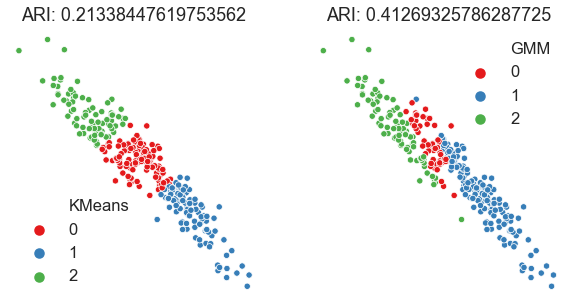

In [9]:
gmm = GaussianMixture(n_components=3, covariance_type="full")
gmm_pred_labels = gmm.fit_predict(X)

gmm_ari = adjusted_rand_score(y, gmm_pred_labels)
print(f"GMM ARI:{gmm_ari}")

kmeans = KMeans(n_clusters=3)
kmeans_pred_labels = kmeans.fit_predict(X)
kmeans_ari = adjusted_rand_score(y, kmeans_pred_labels)
print(f"K-means ARI: {kmeans_ari}")

plot_df["KMeans"] = kmeans_pred_labels
plot_df["GMM"] = gmm_pred_labels

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(
    data=plot_df,
    x=0,
    y=1,
    hue="KMeans",
    ax=axs[0],
    palette=sns.color_palette("Set1", plot_df["KMeans"].nunique()),
    s=40,
)
sns.scatterplot(
    data=plot_df,
    x=0,
    y=1,
    hue="GMM",
    ax=axs[1],
    palette=sns.color_palette("Set1", plot_df["KMeans"].nunique()),
    s=40,
)
axs[0].axis("off")
axs[0].set_title(f"ARI: {kmeans_ari}")
axs[1].axis("off")
axs[1].set_title(f"ARI: {gmm_ari}")


 # Now run an actual experiment over many random inits
 Here is an example of how we could profile the performance of these two algorithms
 over many random samples using Joblib

Text(0.5, 0, '(GMM - KMeans) ARI')

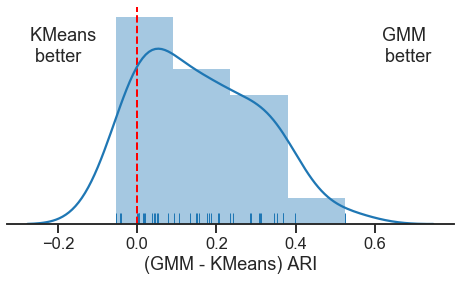

In [10]:
def run_experiment(seed):
    np.random.seed(seed)
    X, y = generate_data()

    gmm = GaussianMixture(n_components=3, covariance_type="full", n_init=20)
    gmm_pred_labels = gmm.fit_predict(X)
    gmm_ari = adjusted_rand_score(y, gmm_pred_labels)

    kmeans = KMeans(n_clusters=3, n_init=20)
    kmeans_pred_labels = kmeans.fit_predict(X)
    kmeans_ari = adjusted_rand_score(y, kmeans_pred_labels)

    return gmm_ari - kmeans_ari


np.random.seed(8888)
n_sims = 40
seeds = np.random.randint(1e8, size=n_sims)  # random
# seeds = np.ones(n_sims, dtype=int) # uncomment for not random
par = Parallel(n_jobs=2)
ari_diffs = par(delayed(run_experiment)(seed) for seed in seeds)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.axvline(0, linewidth=2, linestyle="--", color="red")
sns.distplot(ari_diffs, norm_hist=False)
sns.rugplot(ari_diffs)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
y_range = ylim[1] - ylim[0]
ypos = ylim[0] + y_range * 0.75
x_range = xlim[1] - xlim[0]
ax.text(xlim[0] + 0.05 * x_range, ypos, "KMeans \n better")
ax.text(xlim[1] - 0.05 * x_range, ypos, "GMM \n better", horizontalalignment="right")
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_yticks([])
ax.set_xlabel("(GMM - KMeans) ARI")
